# DATA 101 Final Project

Connor Cozad and Caroline Goodman

## Topic and Question
We want to learn more about the variables associated with weather and tides in Charleston, SC. The questions that arise from this topic are:
- How does temperature and feels like temperature vary over the year?
- How do tides vary throughout the year? How well are tides predicted?

## Background & Prior Work

## Imports

In [284]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)  # Display all columns in DataFrames
plt.rcParams['axes.spines.right'] = False   # Remove top and right borders on plots
plt.rcParams['axes.spines.top'] = False

## Data Sources

<b>Tides</b>: We retrieved hourly tide observations in Charleston Harbor for the same time period (2019, 2020, and 2021) from a <a href='https://tidesandcurrents.noaa.gov/api-helper/url-generator.html'>NOAA Tides and Currents API</a>.

The API only allows us to retrieve one variable at a time, for one year at a time. Therefore, we use a loop to call the API multiple times, and accumulate the DataFrames as they were retrieved, so that we could have multiple years of data in one DataFrame.

In [285]:
water_height = pd.DataFrame()
for year in range(2019, 2022):
    water_height_year = pd.read_csv(f'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date={year}0101&end_date={year}1231&station=8665530&product=hourly_height&datum=MLLW&time_zone=gmt&units=english&format=csv')
    water_height = pd.concat([water_height, water_height_year], ignore_index=True, sort=False)
water_height.head()

,Date Time,Water Level,Sigma,I,L
0,2019-01-01 00:00,2.554,0.000,0,0
1,2019-01-01 01:00,1.409,0.016,0,0
2,2019-01-01 02:00,0.480,0.010,0,0
3,2019-01-01 03:00,0.090,0.010,0,0
4,2019-01-01 04:00,0.539,0.013,0,0


We do the same thing for tide predictions below that we did above for observed water heights.

In [286]:
tide_pred = pd.DataFrame()
for year in range(2019, 2022):
    tide_pred_year = pd.read_csv(f'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date={year}0101&end_date={year}1231&station=8665530&product=predictions&datum=MLLW&time_zone=gmt&units=english&format=csv')
    tide_pred = pd.concat([tide_pred, tide_pred_year], ignore_index=True, sort=False)
tide_pred.head()

,Date Time,Prediction
0,2019-01-01 00:00,2.064
1,2019-01-01 00:06,1.940
2,2019-01-01 00:12,1.817
3,2019-01-01 00:18,1.694
4,2019-01-01 00:24,1.573


We now have two DataFrames, one called `water_height` containing the observed water heights between 2019 and 2021, and another called `tide_pred` containing the predicted water heights between 2019 and 2021.

In order to get these variables into the same table, we want to merge them on the nearest value found in `Date Time` column that both DataFrames contain. Thus, we convert the data type of these columns to a datetime object. Then, we complete the merge.

In [290]:
water_height['Date Time'] = pd.to_datetime(water_height['Date Time'])
tide_pred['Date Time'] = pd.to_datetime(tide_pred['Date Time'])

In [289]:
tides = pd.merge_asof(water_height, tide_pred, direction='nearest', on='Date Time')
tides.head()

,Date Time,Water Level,Sigma,I,L,Prediction
0,2019-01-01 00:00:00,2.554,0.000,0,0,2.064
1,2019-01-01 01:00:00,1.409,0.016,0,0,0.887
2,2019-01-01 02:00:00,0.480,0.010,0,0,0.044
3,2019-01-01 03:00:00,0.090,0.010,0,0,-0.172
4,2019-01-01 04:00:00,0.539,0.013,0,0,0.376


<b>Weather</b>: We retrieved hourly weather observations in Charleston for 2019, 2020, and 2021, from an archive of weather observations maintained by the <a href='https://mesonet.agron.iastate.edu/request/download.phtml?network=SC_ASOS'>Iowa Environmental Mesonet</a>.

In [92]:
wxObs = pd.read_csv("https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=JZI&data=all&year1=2019&month1=1&day1=1&year2=2021&month2=12&day2=31&tz=Etc%2FUTC&format=onlycomma&latlon=no&elev=no&missing=empty&trace=0.0001&direct=no&report_type=1&report_type=2")
wxObs.head(1)

,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar,snowdepth
0,JZI,2019-01-01 00:15,66.2,66.2,100.0,180.0,5.0,0.0,30.13,NaN,0.25,NaN,OVC,NaN,NaN,NaN,100.0,NaN,NaN,NaN,FG,NaN,NaN,NaN,NaN,NaN,NaN,66.2,KJZI 010015Z AUTO 18005KT 1/4SM FG OVC001 19/1...,NaN


We convert the data type of `valid` column to a datetime object in order to merge the weather observations with the tide measurements. 

In [93]:
wxObs['valid'] = pd.to_datetime(wxObs['valid'])

In [99]:
df = pd.merge_asof(tides, wxObs, direction='nearest', left_on='Date Time', right_on='valid')
df.head(1)

,Date Time,Water Level,Sigma,I,L,Prediction,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar,snowdepth
0,2019-01-01,2.554,0.0,0,0,2.064,JZI,2019-01-01 00:15:00,66.2,66.2,100.0,180.0,5.0,0.0,30.13,NaN,0.25,NaN,OVC,NaN,NaN,NaN,100.0,NaN,NaN,NaN,FG,NaN,NaN,NaN,NaN,NaN,NaN,66.2,KJZI 010015Z AUTO 18005KT 1/4SM FG OVC001 19/1...,NaN


## Data Cleaning

After merging the weather and tide data together, we use .info() to view the Non-Null Count in order to observe the number of missing values in each attribute.

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26304 entries, 0 to 26303
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date Time          26304 non-null  datetime64[ns]
 1    Water Level       26304 non-null  float64       
 2    Sigma             26303 non-null  float64       
 3    I                 26304 non-null  int64         
 4    L                 26304 non-null  int64         
 5    Prediction        26304 non-null  float64       
 6   station            26304 non-null  object        
 7   valid              26304 non-null  datetime64[ns]
 8   tmpf               26250 non-null  float64       
 9   dwpf               26250 non-null  float64       
 10  relh               26250 non-null  float64       
 11  drct               25292 non-null  float64       
 12  sknt               25896 non-null  float64       
 13  p01i               26304 non-null  float64       
 14  alti  

Using .dropna(), we drop any row that contains <b>missing values</b>. Notice the loss of the number of entries. Our datset that originally contained over 26,000 rows now contains just over 13,000. 

In [293]:
df = df.dropna()

In [297]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13287 entries, 0 to 26279
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date Time     13287 non-null  datetime64[ns]
 1    Prediction   13287 non-null  float64       
 2    Water Level  13287 non-null  float64       
 3   valid         13287 non-null  datetime64[ns]
 4   tmpf          13287 non-null  float64       
 5   dwpf          13287 non-null  float64       
 6   relh          13287 non-null  float64       
 7   drct          13287 non-null  float64       
 8   sknt          13287 non-null  float64       
 9   p01i          13287 non-null  float64       
 10  alti          13287 non-null  float64       
 11  vsby          13287 non-null  float64       
 12  skyc1         13287 non-null  object        
 13  skyl1         13287 non-null  float64       
 14  feel          13287 non-null  float64       
dtypes: datetime64[ns](2), float64(12), o

After checking and taking care of missing values, we perform <b>feature selection</b> by creating a DataFrame containing only the variables that could help us answer our questions regarding the changing weather and tides in Charleston. 

In [294]:
df = df[['Date Time', ' Prediction', ' Water Level', 'valid', 'tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'p01i','alti','vsby','skyc1','skyl1','feel']]

In just two lines of code, we are able to observe each of the attributes in comparison with each other (and itself). We use these figures to identify possible <b>outliers</b> in our dataset. No outliers were found, so none were altered or removed. 

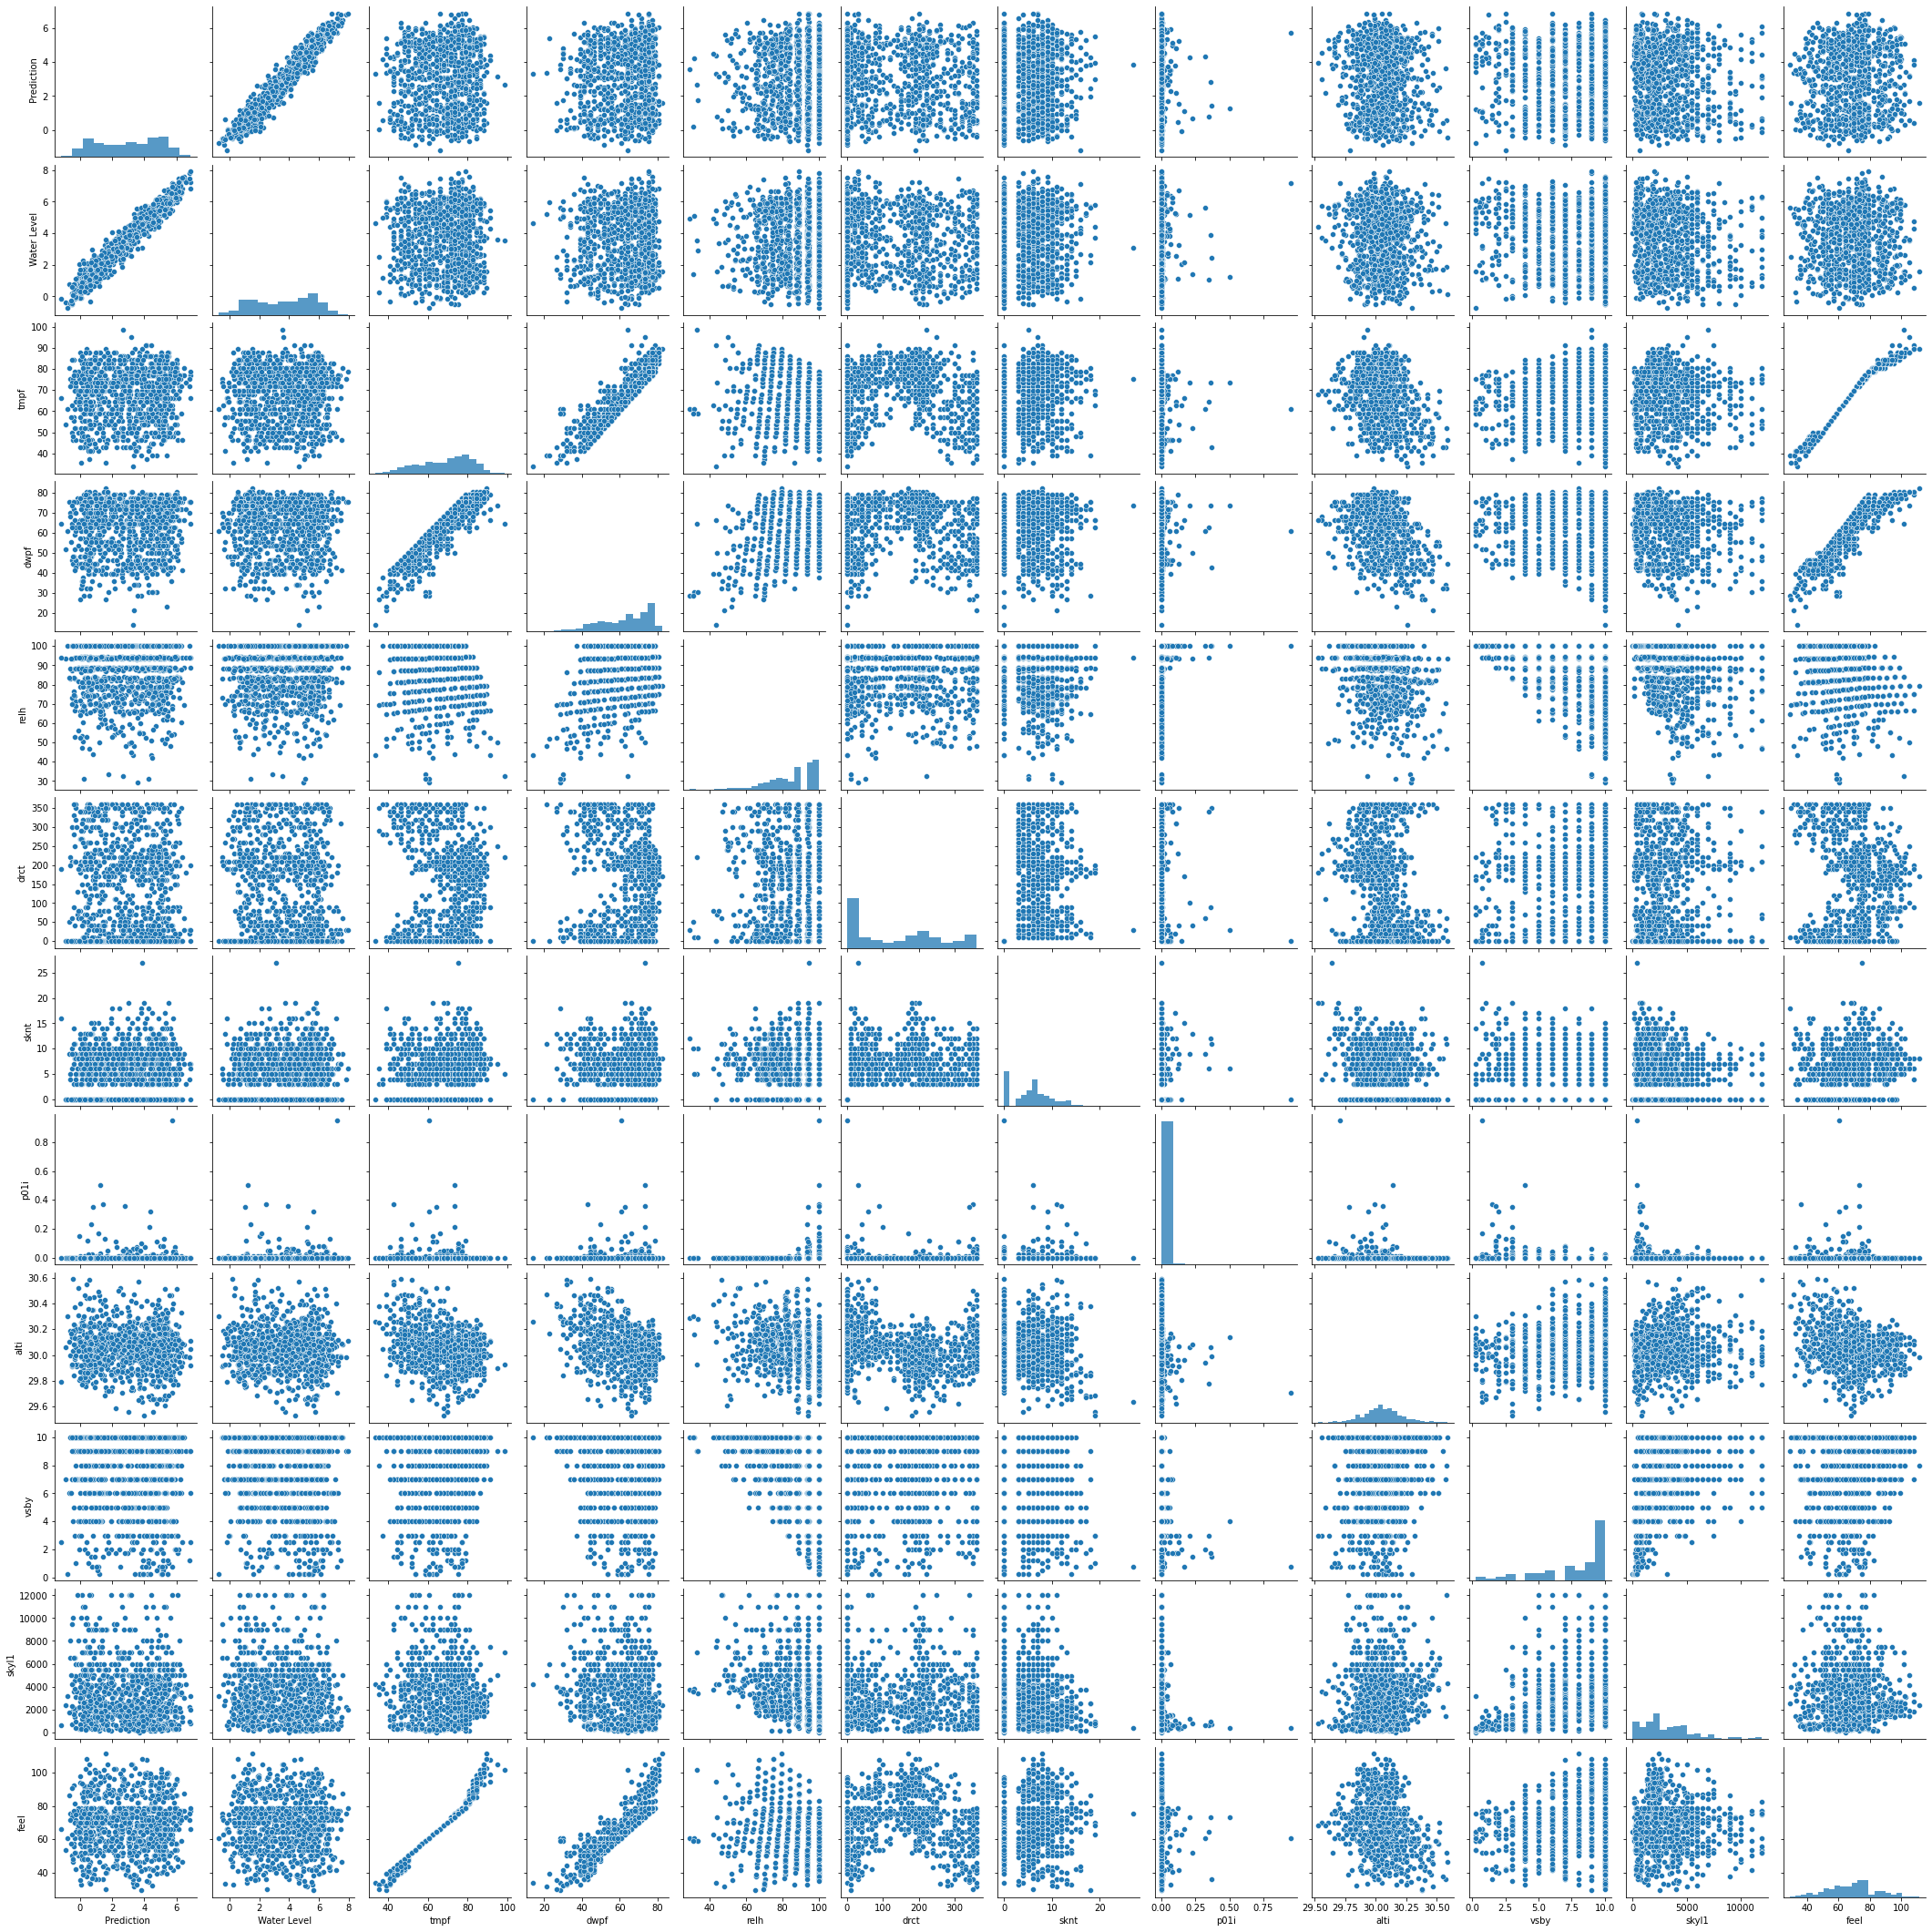

In [295]:
to_plot = df[list(df.select_dtypes(include=['int64', 'float64']).columns)].sample(1000)
_=sns.pairplot(to_plot, diag_kind='hist', diag_kws=dict(linewidth=0))

## Data Visualization/Implementation

We plotted the following figures to observe the relationships between the attributes we believed would further guide us to answering our questions.

In our first visualization, we observe the temperature in Charleston over time (2019-2021). The figure shows the varying temperatures as the seasons change over the year and the variability in the temperature within those seasons. 

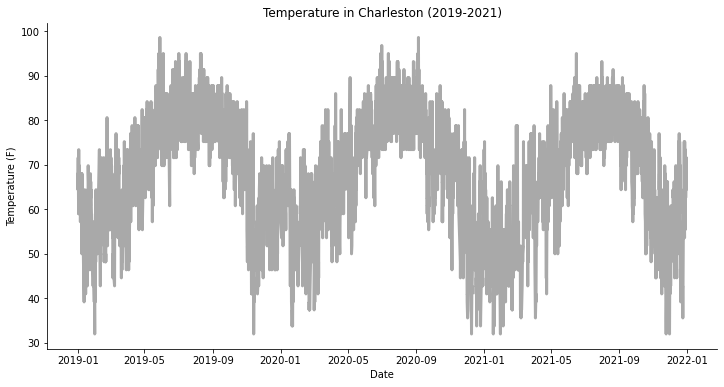

In [280]:
plt.figure(figsize=(12,6))
plt.plot(df['valid'], df['tmpf'], color='darkgray', linewidth=3)
plt.title('Temperature in Charleston (2019-2021)')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
_=plt.show()

We further our analysis of the varying temperatures by incorporating the `feel` attribute. The darker shadow observed on the graph depicts the "feels like" temperature.

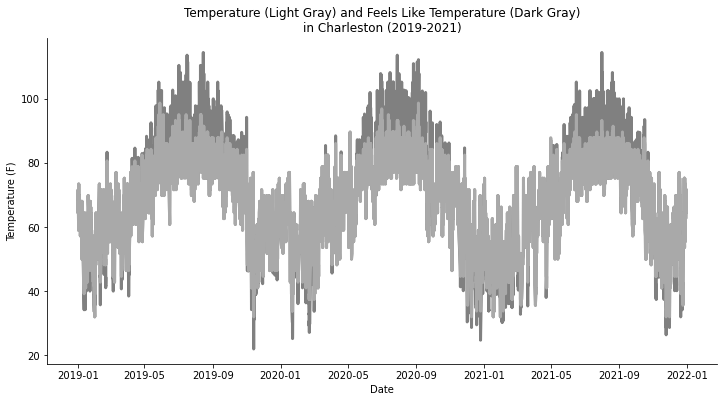

In [282]:
plt.figure(figsize=(12,6))
plt.plot(df['valid'], df['feel'], color='gray', linewidth=3)
plt.plot(df['valid'], df['tmpf'], color='darkgray', linewidth=3)
plt.title('Temperature (Light Gray) and Feels Like Temperature (Dark Gray)\nin Charleston (2019-2021)')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
_=plt.show()

We wanted to look further into the "feels like" temperature in comparison to the actual temperature in Charleston. The graph below provides a visual of the relationship. We observe the heat index and the wind chill at the extremes of the black line, which represents where the actual temperature equals the feels like temperature (y=x).


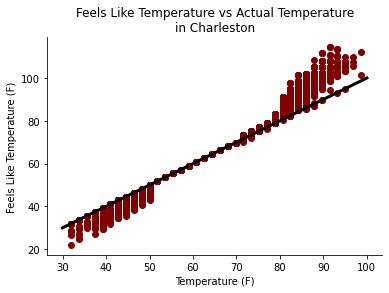

In [250]:
xy_line = np.linspace(30, 100, 2)
plt.plot(xy_line, xy_line, color='black', linewidth=3)
plt.scatter(df['tmpf'], df['feel'], color='maroon', label='Predicted')
plt.title('Feels Like Temperature vs Actual Temperature\nin Charleston')
plt.xlabel('Temperature (F)')
_=plt.ylabel('Feels Like Temperature (F)')

The figure below provides an overall visualization for the water height in Charleston Harbor from the years 2019 to 2021. 

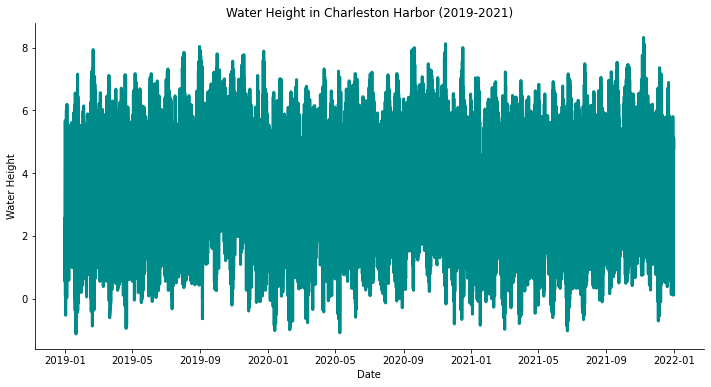

In [269]:
plt.figure(figsize=(12,6))
plt.plot(df['valid'], df[' Water Level'], color='darkcyan', linewidth=3)
plt.title('Water Height in Charleston Harbor (2019-2021)')
plt.xlabel('Date')
plt.ylabel('Water Height')
_=plt.show()

In our final graph, we provide a visualization for the accuracy of NOAA predicted water levels versus observed water levels in Charleston Harbor. From the figure, we observe that the majority of the data lies above the light green line, meaning that the predictions may be slightly underestimating the water levels in Charleston. 

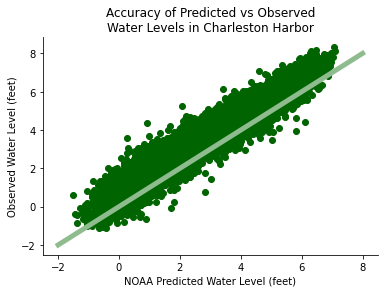

In [283]:
xy_line = np.linspace(-2, 8, 2)
plt.scatter(df[' Prediction'], df[' Water Level'], color='darkgreen', label='Predicted')
plt.plot(xy_line, xy_line, color='darkseagreen', linewidth=5)
plt.title('Accuracy of Predicted vs Observed\nWater Levels in Charleston Harbor')
plt.xlabel('NOAA Predicted Water Level (feet)')
_=plt.ylabel('Observed Water Level (feet)')

## Conclusion

Using a dataset gathered from NOAA, we merged two datasets containing statistics on weather and tide levels in Charleston. We asked how tides and temperatures change throughout the year and how well these organizations are able to predict these tides changing. To clean the data, we checked for <b>missing values</b> and created a DataFrame using <b>feature selection</b> to extract the attributes we believed to be useful in the <b>implementation</b> of our data. Ultimately, we observed that the temperature varies from the feels like temperature in that feels like temperature accounts for <b>wind chill and heat index</b>. We further observed that the predictions slightly underestimated the true water levels in Charleston. A limitation of our data analysis involves the loss of over half of our data when dropping null values. Our datset that originally contained over 26,000 rows now contains just 13,000 rows. 